In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt

print(tf.__version__)

2.10.1


Primera prueba - Test de entrenamiento

In [ ]:
# Parámetros
basePath = '../data'  # Ajusta la ruta si es necesario
train_dir = os.path.join(basePath, 'preprocessed', 'train')  # Ruta para entrenar
val_dir = os.path.join(basePath, 'preprocessed', 'validation')  # Ruta para validar
batch_size = 16
img_size = (224, 224)
num_classes = 15
epochs = 60

In [ ]:
# Generadores de datos con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Cargar la red base preentrenada (MobileNetV2)
base_model = MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,  # No incluir la capa densa de clasificación
    weights='imagenet'  # Cargar los pesos preentrenados en ImageNet
)

# Descongelar algunas capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Congelar todas las capas excepto las últimas 4
    layer.trainable = False

# Añadir capas superiores para nuestra clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',                     # Monitorea la pérdida de validación
    patience=10,                            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True               # Restaura los mejores pesos al final del entrenamiento
)

# Callback para registrar el tiempo por época
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


time_callback = TimeHistory()

# Entrenar el modelo con Early Stopping y el callback de tiempo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, time_callback]
)

loss, accuracy = model.evaluate(validation_generator)
print(f"Pérdida en validación: {loss:.3f}")
print(f"Precisión en validación: {accuracy:.3f}")

# Guardar el modelo entrenado
model.save('../models/re_fa_15_personasV5-gpu.keras')

Evaluacion del Modelo

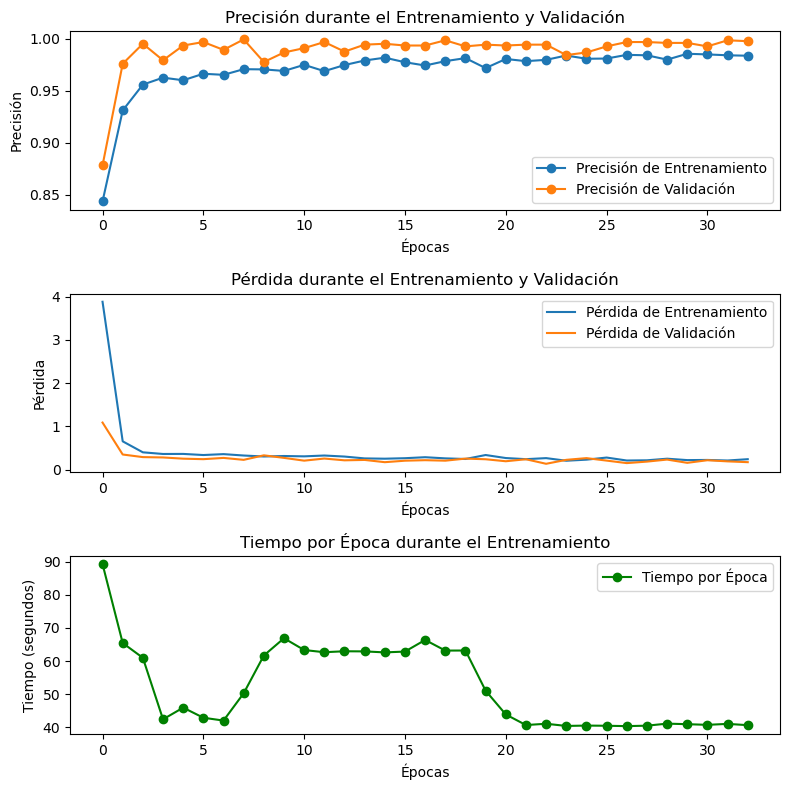

In [6]:
# Función para graficar el rendimiento del modelo
def plot_training(history, epoch_times):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Ensure all lists have the same length
    min_length = min(len(acc), len(val_acc), len(loss), len(val_loss), len(epoch_times))
    acc = acc[:min_length]
    val_acc = val_acc[:min_length]
    loss = loss[:min_length]
    val_loss = val_loss[:min_length]
    epoch_times = epoch_times[:min_length]
    
    epochs_range = range(min_length)  # Ensure epochs_range matches the length of history data

    # Graficar la precisión
    plt.figure(figsize=(8, 8))
    
    plt.subplot(3, 1, 1)
    plt.plot(epochs_range, acc, 'o-',label='Precisión de Entrenamiento')
    plt.plot(epochs_range, val_acc, 'o-',label='Precisión de Validación')
    plt.legend(loc='lower right')
    plt.title('Precisión durante el Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')

    # Graficar la pérdida
    plt.subplot(3, 1, 2)
    plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida durante el Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')

    # Graficar el tiempo por época
    plt.subplot(3, 1, 3)
    plt.plot(epochs_range, epoch_times, 'o-', label='Tiempo por Época', color='green')
    plt.legend(loc='upper right')
    plt.title('Tiempo por Época durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Tiempo (segundos)')

    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()

# Llamar la función para graficar el rendimiento
plot_training(history, time_callback.times)